In [1]:
import warnings
import numpy as np
import xarray as xr
from pathlib import Path
from itertools import groupby
from datetime import timedelta
import matplotlib.pyplot as plt
from main import paths, EUC_particles, ofam_fieldset, get_date
from main import plot3D, ParticleFile_transport, timer

fpath, dpath, xpath = paths()
tpath = Path('/g', 'data3', 'hh5', 'tmp', 'as3189', 'OFAM')
date_bnds = [get_date(1979, 1, 1), get_date(2014, 12, 'max')]
# date_bnds = [get_date(2070, 1, 1), get_date(2101, 12, 'max')]
temp = []
 
for y in range(date_bnds[0].year, date_bnds[1].year + 1):
    for m in range(date_bnds[0].month, date_bnds[1].month + 1):
        temp.append(tpath.joinpath('ocean_temp_{}_{:02d}.nc'.format(y, m)))

ds = xr.open_mfdataset(temp)

# Select the SST averaged over the nino3.4 area.
sst = ds.sel(yt_ocean=slice(-5, 5), xt_ocean=slice(190, 240), st_ocean=2.5)
sst = sst.temp.mean(['yt_ocean', 'xt_ocean'])

# SST monthly climatology.
sst_clim = sst.groupby('Time.month').mean('Time')

# SST anomoly.
sst_anom = sst.groupby('Time.month') - sst_clim

# ONI index.
oni = sst_anom.rolling(Time=5).mean(dim='Time')

In [2]:
# Create a categorical dataarray of events.
oni.load() # Need to load oni first.
nino34 = xr.full_like(oni, 'none', dtype='U4')
nino34[oni >= 0.5] = 'nino'
nino34[oni <= -0.5] = 'nina'

In [3]:
# Count the length time of each neutral, nino and nina. 
count_dups = [sum(1 for _ in grp) for _, grp in groupby(nino34)]

# Count the length time of each neutral event.
count_none = [sum(1 for _ in grp) for _, grp in groupby(nino34) if _ == 'none']

# Find the longest neutral event.
max_len = np.max(count_none)

# Find the index where the max event starts (in the count).
max_idx_dup = np.where(count_dups == max_len)[0][0]

# Sum the previous days to find index of event in nino34 array.
max_idx = sum(count_dups[0:max_idx_dup])

In [4]:
if not all(x == 'none' for x in nino34[max_idx:max_idx + max_len]):
    warnings.warn('Not all values are none.')
if nino34[max_idx -1] == 'none':
    warnings.warn('Previous time is not none.')
if nino34[max_idx + max_len] == 'none':
    warnings.warn('Next day is not none.')

print('Longest event: {} days'.format(max_len))
print('Index in count:', max_idx_dup)
print('Index in nino34:', max_idx)
strt = nino34[max_idx].Time.item()
end = nino34[max_idx + max_len].Time.item()
print('Start date:', strt)
print('End date:', end)

Longest event: 725 days
Index in count: 108
Index in nino34: 8856
Start date: 2003-04-01 12:00:00
End date: 2005-03-26 12:00:00


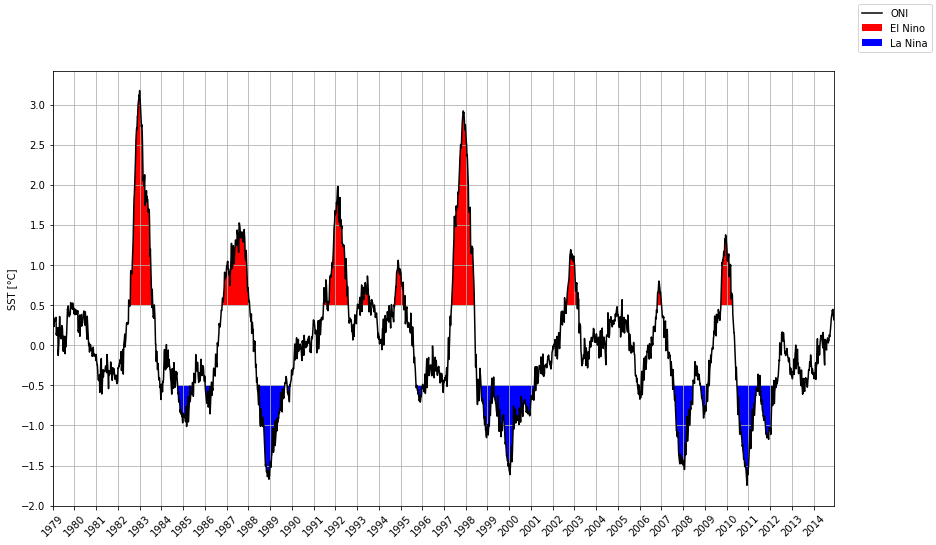

In [5]:
fig, ax = plt.subplots(figsize=(14, 8))
# ax.plot(oni.Time, sst_anom, 'green', label='SST_anom')
ax.plot(oni.Time, oni, 'k', label='ONI')

ax.fill_between(oni.Time.values, oni, 0.5, where=(oni>=0.5), facecolor='r', label='El Nino')
ax.fill_between(oni.Time.values, oni, -0.5, where=(oni<=-0.5), facecolor='b', label='La Nina')

ticks_to_use = oni.Time.values[::366]
labels = [ i.strftime("%-Y") for i in ticks_to_use ]
ax.set_xlim(oni.Time[0].item(), oni.Time[-1].item())
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels, rotation=45)
ax.set_yticks(np.arange(-2, 3.5, 0.5))
ax.set_ylabel('SST [°C]')
ax.grid()
fig.legend()
plt.savefig(fpath.joinpath('ONI_{}-{}.png'.format(date_bnds[0].year, date_bnds[-1].year)))